<a href="https://colab.research.google.com/github/enisba/inzva_DLSG_notebook/blob/main/Assignment1_1_debugging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: The Broken Experiment

## Debugging a Failing Deep Learning Pipeline

---

### Background

Your colleague has been trying to train a Multi-Layer Perceptron (MLP) to predict **California housing prices** using the classic California Housing dataset. However, their training pipeline is producing terrible results — the loss explodes, the predictions are nonsensical, and they can't figure out why.

They've asked you for help. Your job is to **find and fix all the bugs** in this notebook.

### Instructions

1. **Read through the entire notebook** before making changes. Understand the intent of each cell.
2. **Identify at least 6 bugs** across data preprocessing, model architecture, loss function, training loop, and evaluation.
3. For **each bug you find**, add a markdown cell explaining:
   - What the bug is
   - Why it causes training to fail (cite the relevant theory)
   - How you fixed it

### Hints

The bugs fall into these categories:
- **Data** (2 bugs)
- **Model Architecture** (1 bug)
- **Loss / Optimization** (2 bugs)
- **Evaluation / Methodology** (1 bug)

Good luck!

## Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

print("PyTorch version:", torch.__version__)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.9.0+cu128
Device: cuda


## Load and Prepare the Data

We load the California Housing dataset. It contains 8 features (median income, house age, average rooms, etc.) and the target is the **median house value** (in units of $100,000).

In [2]:
# Load dataset
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print("Feature columns:", list(X.columns))
print("Dataset shape:", X.shape)
print("Target range: [{:.2f}, {:.2f}]".format(y.min(), y.max()))

Feature columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Dataset shape: (20640, 8)
Target range: [0.15, 5.00]


**BUG 1** -Target was added into the features with X['MedHouseVal'] = y, causing data leakage.

**BUG 2** - No Scaling features were not scaled, which can cause exploding gradients during training.

In [3]:
# Add target to the dataframe for "convenience"
from sklearn.preprocessing import StandardScaler
# X['MedHouseVal'] = y

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("Number of input features:", X_train.shape[1])

Training set size: (16512, 8)
Test set size: (4128, 8)
Number of input features: 8


In [4]:
# Convert to PyTorch tensors — feeding raw features directly
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Feature sample (first row):", X_train_tensor[0])
print("Feature means:", X_train_tensor.mean(dim=0))
print("Feature stds:", X_train_tensor.std(dim=0))

Feature sample (first row): tensor([-0.3262,  0.3485, -0.1749, -0.2084,  0.7683,  0.0514, -1.3728,  1.2726])
Feature means: tensor([-1.5017e-09,  9.2410e-09, -1.1551e-10,  0.0000e+00, -6.9308e-10,
        -9.2410e-10,  2.3103e-09,  0.0000e+00])
Feature stds: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


## Define the Model

We build a simple MLP with 3 hidden layers for regression.

**BUG 3**- We are doing regression to predict house prices, not classification. We have only one output neuron softmax will always return 1.0

In [5]:
class HousingMLP(nn.Module):
    def __init__(self, input_dim):
        super(HousingMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            # nn.Softmax(dim=1)  # Output activation for regression
        )

    def forward(self, x):
        return self.network(x)


input_dim = X_train_tensor.shape[1]
model = HousingMLP(input_dim)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

HousingMLP(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 11,521


## Define Loss and Optimizer

**BUG 4** -nn.CrossEntropyLoss() is using for classification. i changed it to nn.MSELoss which is the standard for regression.

**BUG 5** - lr is so high cause of exploding gradients i changed lr  0.001

In [6]:
# Loss function for our regression task
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training Loop

In [7]:
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """
    Standard training loop.
    Returns a list of average training loss per epoch.
    """
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        for X_batch, y_batch in train_loader:
            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] — Train Loss: {avg_loss:.4f}")

    return train_losses

In [8]:
# Run training
NUM_EPOCHS = 50
losses = train_model(model, train_loader, criterion, optimizer, epochs=NUM_EPOCHS)

Epoch [10/50] — Train Loss: 0.2912
Epoch [20/50] — Train Loss: 0.2673
Epoch [30/50] — Train Loss: 0.2552
Epoch [40/50] — Train Loss: 0.2468
Epoch [50/50] — Train Loss: 0.2356


## Evaluate the Model

**BUG 6** - code evaluate using train_loader so seen data changing test_loader for measure performance for unseen data

In [9]:
def evaluate_model(model, data_loader):
    """
    Evaluate model and return MSE and MAE.
    """
    model.eval()
    all_preds = []
    all_targets = []

    for X_batch, y_batch in data_loader:
        with torch.no_grad():
            preds = model(X_batch)
        all_preds.append(preds)
        all_targets.append(y_batch)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    mse = torch.mean((all_preds - all_targets) ** 2).item()
    mae = torch.mean(torch.abs(all_preds - all_targets)).item()
    return mse, mae


# train_mse, train_mae = evaluate_model(model, train_loader)
test_mse, test_mae = evaluate_model(model, test_loader)

print("=" * 50)
print("          MODEL EVALUATION RESULTS")
print("=" * 50)
print(f"  MSE:  {test_mse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print("=" * 50)
print("\nThe model is performing great!")

          MODEL EVALUATION RESULTS
  MSE:  0.2655
  MAE:  0.3411

The model is performing great!


## Visualize Training

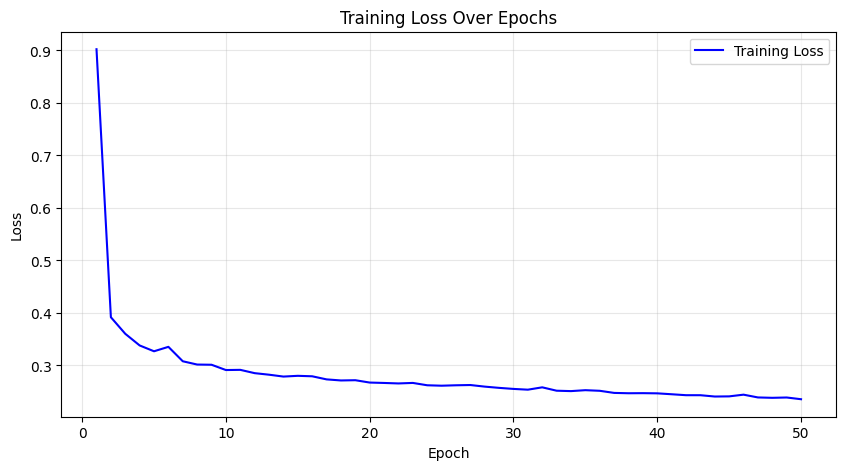

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()